In [35]:
include("Create_Sample.jl")
include("MIP_SPLIT.jl")
include("Split.jl")
include("GA.jl")
include("Initial.jl")
include("Mutation.jl")
include("Crossover.jl")
include("Neighborhood.jl")
include("Neighborhood_intra.jl")
include("costs.jl")
include("Draw.jl")
include("Escape.jl")
include("cross_escape.jl")
include("intersection.jl")

two_opt_on_route (generic function with 1 method)

In [48]:
instance = :eil51
T = Read_TSPLIB_instance(instance, 1)
n_nodes = size(T)[1]-2
tsp = readTSPLIB(instance)
allNodes = tsp.nodes
depot = allNodes[1, :]

Customers = allNodes[2:n_nodes+1, :]

K = 5
P = Chromosome[]
best_chrm = Chromosome(Int[], 0.0, 0.0, Tour[])
worst_chrm = Chromosome(Int[], 0.0, 0.0, Tour[])
all_chrms = Chromosome[]
crossover_functions = [5,7,8]
time_limit = Inf
demands = ones(Int, n_nodes)
W = 150
h = 0.3
popsize = (20,40)
k_tournament = 2
num_iter = 2000
Mutation_Chance = 0.0

num_runs = 10
num_nei = 2
avg = 0.0
best = Inf
worst = 0.0
t1 = time() 
best_chrms = Chromosome[]
for i=1:num_runs
    P, roullet = Perform_Genetic_Algorithm(T, demands,K, W, h, popsize, 
                k_tournament, num_iter, time_limit, Mutation_Chance, num_nei, crossover_functions, Customers, depot);
    push!(best_chrms, P[1])
    avg += P[1].fitness
    push!(all_chrms, P[1])
    if P[1].fitness < best
        best = P[1].fitness
        best_chrm = P[1]
    end
    if P[1].fitness > worst
        worst = P[1].fitness
        worst_chrm = P[1]
    end
end
t2 = time()
println("Results for ,m=", K)
println("Best: ", round(best, digits = 1), "  Average: ", round(avg/num_runs, digits = 1), 
    "  Worst: ", round(worst, digits = 1), " , run time= ", round((t2-t1)/num_runs, digits=2))


The best objective achieved in 3896 generations is: 124.71278348252798 and it took 2.812999963760376 seconds.
The best objective achieved in 8152 generations is: 123.51814214859134 and it took 3.8470001220703125 seconds.
The best objective achieved in 4546 generations is: 121.11996336581998 and it took 2.632999897003174 seconds.
The best objective achieved in 5762 generations is: 120.05448678403047 and it took 2.821000099182129 seconds.
The best objective achieved in 4859 generations is: 118.53957255724328 and it took 2.31499981880188 seconds.
The best objective achieved in 4776 generations is: 123.38738900942475 and it took 2.2639999389648438 seconds.
The best objective achieved in 2476 generations is: 125.4783077602918 and it took 1.2360000610351562 seconds.
The best objective achieved in 6666 generations is: 120.89216871690186 and it took 3.200000047683716 seconds.
The best objective achieved in 4809 generations is: 120.05448678403044 and it took 2.2849998474121094 seconds.
The best

Tour 1:
50 17 3 40 18 41 43 36 16 11 45 31 
cost=118.16766009305134
Tour 2:
10 37 4 14 44 32 38 9 48 8 15 1 
cost=120.99134767167118
Tour 3:
26 47 5 22 23 42 6 25 7 30 27 
cost=120.72512403800124
Tour 4:
13 24 12 39 46 
cost=121.60814122416593
Tour 5:
2 35 34 19 28 20 33 29 49 21 
cost=119.1530343412609


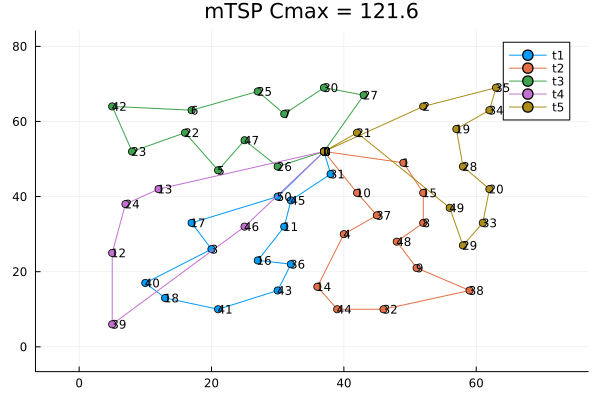

In [90]:
sol = 10
Draw_Solution(all_chrms[sol], depot, Customers, "mTSP", all_chrms[sol].fitness)

Tour 1:
50 46 18 41 43 36 16 11 45 31 
cost=109.23962606618116
Tour 2:
10 37 4 14 44 32 38 9 48 8 15 
cost=118.67910228723898
Tour 3:
26 13 24 12 39 40 3 17 
cost=126.3306659595072
Tour 4:
47 5 22 23 42 6 25 7 30 27 
cost=116.42985789951305
Tour 5:
1 49 29 33 20 28 19 34 35 2 21 
cost=113.99886687953146


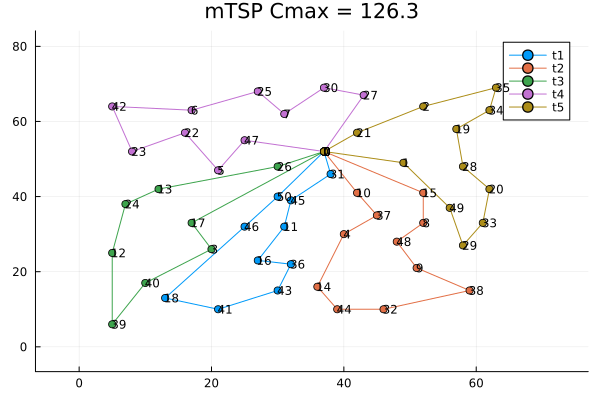

In [91]:
chrm = deepcopy(all_chrms[sol])

# t = [copy(chrm.tours[i].Sequence) for i=1:K];

# find_intersections(t[3], t[2], Customers, depot)
Solve_all_intersections(chrm, Customers, depot, T)
Draw_Solution(chrm, depot, Customers, "mTSP", chrm.fitness)

In [149]:
function Improve_after_removing_intersections(tours::Vector{Tour}, T::Matrix{Float64}, n_nodes::Int, m::Int, Customers::Matrix{Float64}, depot::Vector{Float64})
    sort!(tours, by=x->x.cost, rev=true)
    means = [mean(Customers[t1, :], dims=1)[1,:] for t1 in [tours[i].Sequence for i=1:m]]

    distances = zeros(m, m)
    for i = 1:m-1
        for j = i+1:m
            distances[i,j] = euclidean(means[i], means[j])
            distances[j,i] = distances[i,j]
        end
    end

    all_tours = [i for i=1:m]

    current_tour = 1
    while true
        next_tours = sortperm(distances[current_tour,:])[2:min(m,3)]
        
        for next_tour in next_tours
            t1 = copy(tours[current_tour].Sequence)
            cost1 = tours[current_tour].cost
            t2 = copy(tours[next_tour].Sequence)
            cost2 = tours[next_tour].cost
            for i=1:length(t1)
                new_cost1 = Calculate_new_cost_remove_one(t1, cost1, i, T, n_nodes)
                new_cost2 = Inf
                best_position = 0
                for j = 1:length(t2)+1
                    temp = Calculate_new_cost_add_one(t2, cost2, t1[i], j, T, n_nodes)
                    if temp < new_cost2 
                        new_cost2 = temp
                        best_position = j
                    end
                end
                if new_cost2 < cost1 
                    if i == 0 
                        node1 = depot
                        node2 = Customers[t1[i+1],:]
                    elseif i == length(t1)
                        node1 = Customers[t1[i],:]
                        node2 = depot
                    else
                        node1 = Customers[t1[i],:]
                        node2 = Customers[t1[i+1],:]
                    end
                    if j == 0 
                        node3 = depot
                        node4 = Customers[t2[j+1],:]
                    elseif j == length(t2)
                        node3 = Customers[t2[j],:]
                        node4 = depot
                    else
                        node3 = Customers[t2[j],:]
                        node4 = Customers[t2[j+1],:]
                    end

                    if segments_intersect_orient(node1, node2, node3, node4)
                        return i, j, true
                    end

        cities = findall(x->x in Candidates, t1)
        Remove_cities_from_one_tour(chrm.tours[current_tour], cities, T, n_nodes)
        deleteat!(chrm.tours[current_tour].Sequence, sort(cities))
        for city in Candidates
            put_city_in_one_tour(chrm.tours[next_tour], city, T, n_nodes)
        end

        deleteat!(all_tours, findfirst(x->x==current_tour, all_tours))
        current_tour = next_tour
    end
    chrm.genes = Int[]
    chrm.fitness = 0
    for tour in chrm.tours
        chrm.genes = vcat(chrm.genes, tour.Sequence)
        if chrm.fitness < tour.cost
            chrm.fitness = tour.cost
        end
    end
    obj, trips = SPLIT(T, demands, m, W, chrm.genes)
    chrm1 = Chromosome(chrm.genes, obj, 0.0, trips)
    return chrm1
end

50 46 16 36 43 41 18 39 40 12 24 17 3 11 45 

161.390385392883

In [93]:
A = rand(3,4)

3×4 Matrix{Float64}:
 0.326026  0.0127263  0.941495   0.147267
 0.273272  0.100689   0.0786392  0.556184
 0.139622  0.745304   0.269631   0.301057

In [98]:
sortperm(A[1,:])[2:2]

1-element Vector{Int64}:
 4

In [109]:
t1, t2 = Solve_one_intersections(t1, t2, T, 12, 11)

for i in t1
    print(i, "  ")
end
println()
for i in t2
    print(i," ")
end

47  22  42  23  13  24  12  40  39  18  41  16  3  17  46  50  5  26  
10 37 4 48 9 38 32 44 14 43 36 11 45 31 

on_segment (generic function with 1 method)

In [40]:
a  = [1.0, 1.0]
b = [-1.0, -1.0]
c = [2.0, -1.0]
d = [5.0, 1.0]

segments_intersect_orient(a,b,c,d)

false

find_intersections (generic function with 1 method)

Solve_one_intersections (generic function with 1 method)

Solve_all_intersections (generic function with 1 method)

two_opt_on_route (generic function with 1 method)

In [84]:
Customers[47,:] - Customers[22,:]

2-element Vector{Float64}:
  9.0
 -2.0

In [101]:
chrm

Chromosome([7, 6, 25, 30, 27, 2, 35, 34, 19, 28  …  13, 24, 12, 40, 39, 18, 41, 16, 11, 45], 167.04482724835538, 136.0428807707649, Tour[Tour([7, 6, 25, 30, 27, 2, 35, 34, 19, 28, 20, 33, 29, 8, 49, 15, 1, 21], 167.04482724835538), Tour([31, 26, 5, 50, 46, 17, 3, 36, 43, 14, 44, 32, 38, 9, 48, 4, 37, 10], 165.2710025018758), Tour([47, 22, 42, 23, 13, 24, 12, 40, 39, 18, 41, 16, 11, 45], 163.1802949288973)])

In [17]:
t1 = [17, 40, 39, 18, 41, 11] 
cost1 = 121.3543781414974
tour1 = Tour(t1, cost1)
t2 = [37, 4, 32, 44, 14, 43, 36, 16, 3, 46, 50, 45] 
cost2 = 119.93453109192447
tour2 = Tour(t2, cost2)

t3 = [21, 1, 28, 20 ,33, 29, 38, 9, 48, 8, 49, 15, 10, 31] 
cost3=119.5913775731072
tour3 = Tour(t3, cost3)
t4 = [26, 5, 13, 12, 24, 23, 42] 
cost4=119.53199648198039
tour4 = Tour(t4, cost4)
t5 = [47, 22, 6, 25, 7, 30, 27, 2, 35, 34, 19] 
cost5 = 117.21148839458516
tour5 = Tour(t5, cost5)
chrm = Chromosome(Int[], 0.0 , 0.0 , [tour1, tour2, tour3, tour4, tour5])
for tour in chrm.tours
    chrm.genes = vcat(chrm.genes, tour.Sequence)
    if chrm.fitness < tour.cost
        chrm.fitness = tour.cost
    end
end

In [18]:
chrm

Chromosome([17, 40, 39, 18, 41, 11, 37, 4, 32, 44  …  22, 6, 25, 7, 30, 27, 2, 35, 34, 19], 121.3543781414974, 0.0, Tour[Tour([17, 40, 39, 18, 41, 11], 121.3543781414974), Tour([37, 4, 32, 44, 14, 43, 36, 16, 3, 46, 50, 45], 119.93453109192447), Tour([21, 1, 28, 20, 33, 29, 38, 9, 48, 8, 49, 15, 10, 31], 119.5913775731072), Tour([26, 5, 13, 12, 24, 23, 42], 119.53199648198039), Tour([47, 22, 6, 25, 7, 30, 27, 2, 35, 34, 19], 117.21148839458516)])

Tour 1:
17 40 39 18 41 11 
cost=121.3543781414974
Tour 2:
37 4 32 44 14 43 36 16 3 46 50 45 
cost=119.93453109192447
Tour 3:
21 1 28 20 33 29 38 9 48 8 49 15 10 31 
cost=119.5913775731072
Tour 4:
26 5 13 12 24 23 42 
cost=119.53199648198039
Tour 5:
47 22 6 25 7 30 27 2 35 34 19 
cost=117.21148839458516


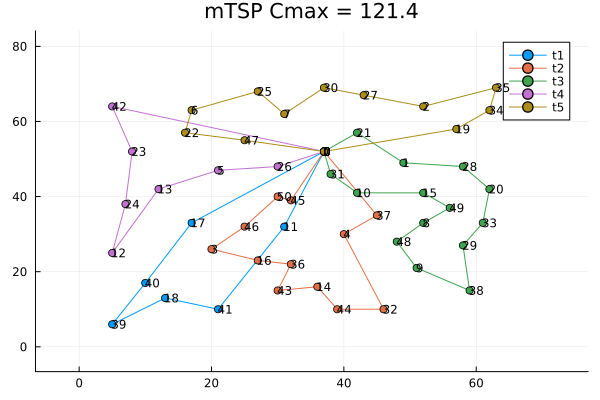

In [19]:
Draw_Solution(chrm, depot, Customers, "mTSP", chrm.fitness)

In [20]:
include("intersection.jl")
Solve_all_intersections(chrm, Customers, depot, T)

Tour 1:
17 40 39 18 41 3 46 50 45 
cost=125.74757978101573
Tour 2:
15 49 8 48 9 38 29 33 20 28 1 
cost=110.37466929536727
Tour 3:
31 10 37 4 32 44 14 43 36 16 11 
cost=110.04533821520512
Tour 4:
26 5 13 12 24 23 42 22 47 
cost=119.98324764526144
Tour 5:
21 19 34 35 2 27 30 7 25 6 
cost=113.58904012358501


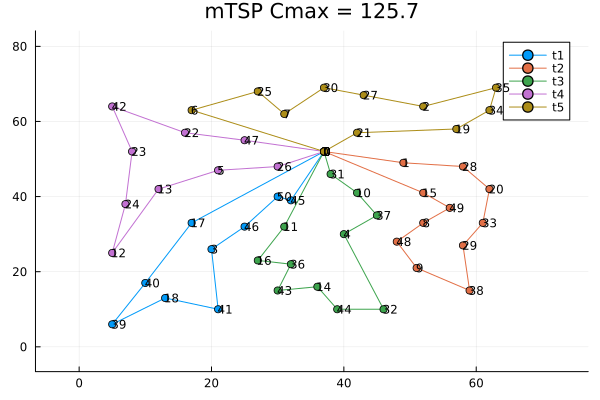

In [21]:
Draw_Solution(chrm, depot, Customers, "mTSP", chrm.fitness)

In [15]:
tour = chrm.tours[1]
tour1 = tour.Sequence
cost1 = tour.cost
nt = length(tour1)
# improved = true
# while improved
#     improved = false
for i1 = 1:nt-1
#         if improved 
#             break
#         end
    for i2 = i1+1:nt

        new_cost = Calculate_new_cost_2_opt(tour1, cost1, i1, i2, T, n_nodes)
        if new_cost < cost1 
            print(i1, "  ", i2)
        end
    end
end
#                 cost1 = new_cost
#                 improved = true
#                 tour1[i1:i2] = reverse(tour1[i1:i2])
#                 tour.cost = new_cost
#                 break
#             end
#         end
#     end    
# end

1  9

In [16]:
new_cost = Calculate_new_cost_2_opt(tour1, cost1, 1, 9, T, n_nodes)

125.74757978101572

In [44]:
i = 4
j = 5
tour1 = chrm.tours[i].Sequence
tour2 = chrm.tours[j].Sequence
# for i in tour1
#     print(i," ")
# end
# println()
# for i in tour2
#     print(i," ")
# end
k1, k2 , intersected = find_intersections(tour1, tour2, Customers, depot)

(0, 0, false)

In [41]:
t1 , t2, c1, c2 = Solve_one_intersections(tour1, tour2, T, k1, k2)

([26, 5, 13, 12, 24, 23, 42, 22, 47], [21, 19, 34, 35, 2, 27, 30, 7, 25, 6], 119.98324764526144, 113.58904012358501)

In [42]:
tour1 = copy(t1)
tour2 = copy(t2)
chrm.tours[i].cost = c1
chrm.tours[j].cost = c2
chrm.tours[i].Sequence = tour1
chrm.tours[j].Sequence = tour2

10-element Vector{Int64}:
 21
 19
 34
 35
  2
 27
 30
  7
 25
  6

Tour 1:
17 40 39 18 41 3 46 50 45 
cost=125.74757978101573
Tour 2:
15 49 8 48 9 38 29 33 20 28 1 
cost=110.37466929536727
Tour 3:
31 10 37 4 32 44 14 43 36 16 11 
cost=110.04533821520512
Tour 4:
26 5 13 12 24 23 42 22 47 
cost=119.98324764526144
Tour 5:
21 19 34 35 2 27 30 7 25 6 
cost=113.58904012358501


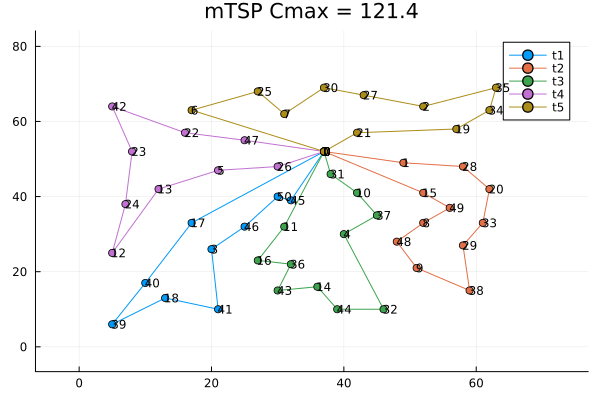

In [43]:
Draw_Solution(chrm, depot, Customers, "mTSP", chrm.fitness)

In [ ]:
for tour in chrm.tours
    two_opt_on_route(tour, T, n_nodes)
end

In [ ]:
m = length(chrm.tours)
    n_nodes = length(chrm.genes)
    for i = 1:m-1
        for j = i+1:m
            tour1 = chrm.tours[i].Sequence
            tour2 = chrm.tours[j].Sequence
            intersected = true
            while intersected 
                k1, k2 , intersected = find_intersections(tour1, tour2, Customers, depot)
                if intersected 
                    t1 , t2, c1, c2 = Solve_one_intersections(tour1, tour2, T, k1, k2)
                    tour1 = copy(t1)
                    tour2 = copy(t2)
                    chrm.tours[i].cost = c1
                    chrm.tours[j].cost = c2
                    chrm.tours[i].Sequence = tour1
                    chrm.tours[j].Sequence = tour2
                end
            end
        end
    end
    for tour in chrm.tours
        two_opt_on_route(tour, T, n_nodes)
    end
    chrm.genes = Int[]
    chrm.fitness = 0.0
    for tour in chrm.tours
        chrm.genes = vcat(chrm.genes, tour.Sequence)
        if chrm.fitness < tour.cost
            chrm.fitness = tour.cost
        end
    end

In [ ]:
convert